# Cereal Dataset 

This notebook runs through analysis of the [cereal](https://www.kaggle.com/crawford/80-cereals) dataset from kaggle.com. 

It contains information on 80 cereals including rating and nutritional value. We will see if we can predict sugar content based off data from the other variables. 

***

First, we will import the necessary modules and create our file paths.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

data_raw_path = "../data-raw"
data_output_path = "../data-output"
cereal_filename = "cereal.csv"

cereal_filepath = data_raw_path + "/" + cereal_filename

## EDA 
Now let's load in the data set and take a quick look

In [2]:
cereal_raw = pd.read_csv(cereal_filepath)
cereal_raw.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843


In [3]:
cereal_raw.shape
print(f"""
The cereal dataset contains {cereal_raw.shape[0]} rows 
and {cereal_raw.shape[1]} columns
""")


The cereal dataset contains 77 rows 
and 16 columns



#### Any missing data?

Let's check if there are any missing values we need to take care of.

In [4]:
assert cereal_raw.isna().any().sum() == 0
cereal_raw.isna().any()

name        False
mfr         False
type        False
calories    False
protein     False
fat         False
sodium      False
fiber       False
carbo       False
sugars      False
potass      False
vitamins    False
shelf       False
weight      False
cups        False
rating      False
dtype: bool

Great! It looks like the dataset has no missing values.

***

Let's continue by exploring some descriptive statistics

In [5]:
cereal_raw.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


#### Insights 

We can immediately see that `carbo`, `sugars`, and `potass` have a minimum value that is negative. We will need to take a closer look at these values.

In [6]:
# Why are some carbo, sugars, potass < 0? 
cereal_raw.query('carbo < 0 | sugars < 0 | potass < 0')

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
20,Cream of Wheat (Quick),N,H,100,3,0,80,1.0,21.0,0,-1,0,2,1.0,1.00,64.533816
57,Quaker Oatmeal,Q,H,100,5,2,0,2.7,-1.0,-1,110,0,1,1.0,0.67,50.828392


Since there are only three rows where these quirky values appear, we will drop these rows from our dataset.

In [7]:
cereal_df = cereal_raw.loc[
    (cereal_raw["carbo"] >= 0) & 
    (cereal_raw["sugars"] >= 0) & 
    (cereal_raw["potass"] >= 0)
]

In [8]:
cereal_df.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,107.027027,2.513514,1.000000,162.364865,2.175676,14.729730,7.108108,98.513514,29.054054,2.216216,1.030811,0.821622,42.371787
std,19.843893,1.075802,1.006826,82.769787,2.423391,3.891675,4.359111,70.878681,22.294352,0.832067,0.153416,0.235715,14.033712
min,50.000000,1.000000,0.000000,0.000000,0.000000,5.000000,0.000000,15.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,135.000000,0.250000,12.000000,3.000000,41.250000,25.000000,1.250000,1.000000,0.670000,32.449210
50%,110.000000,2.500000,1.000000,180.000000,2.000000,14.500000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.253086
75%,110.000000,3.000000,1.000000,217.500000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.520611
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


Now the values make more sense.

***

## Visualizations
Next we will make some visualizations of our data.

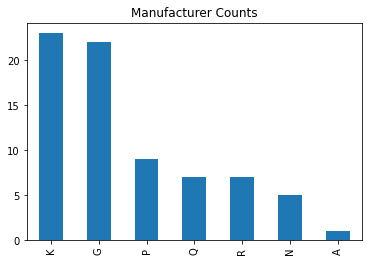

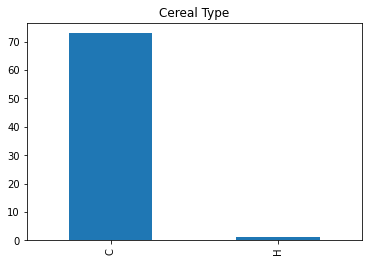

In [9]:
# Visualizations 
cereal_df["mfr"].value_counts().plot(kind="bar")
plt.title("Manufacturer Counts")
plt.show()

cereal_df["type"].value_counts().plot(kind="bar")
plt.title("Cereal Type");

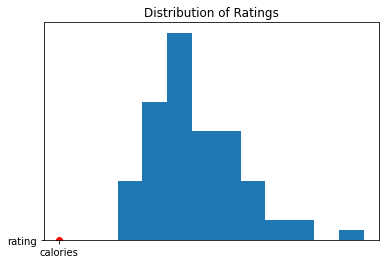

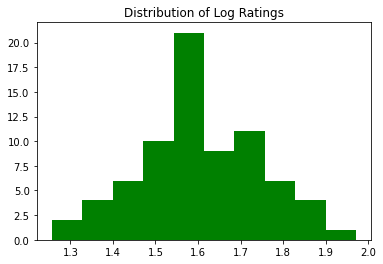

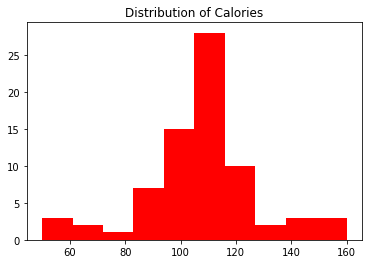

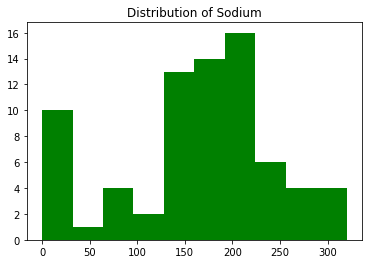

In [10]:
plt.scatter(
    x="calories", 
    y="rating", 
    data="cereal_df",
    color="red"
);
cereal_df["rating"].hist(grid=False)
plt.title("Distribution of Ratings");
plt.show()

np.log10(cereal_df["rating"]).hist(grid=False, color="green")
plt.title("Distribution of Log Ratings");
plt.show()


cereal_df["calories"].hist(grid=False, color="red")
plt.title("Distribution of Calories");
plt.show()

cereal_df["sodium"].hist(grid=False, color="green")
plt.title("Distribution of Sodium");

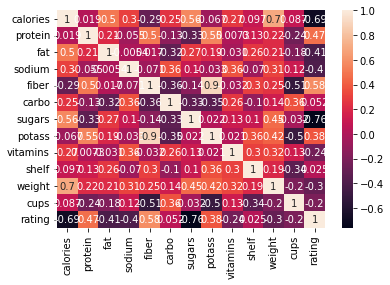

In [11]:
cereal_cor = cereal_raw.corr()
sns.heatmap(cereal_cor, annot=True);

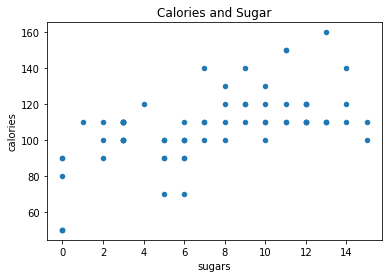

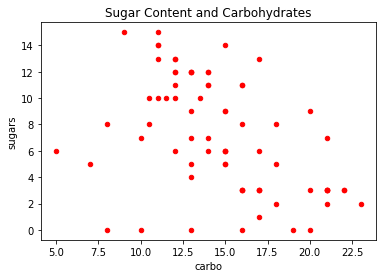

In [12]:
cereal_df.plot("sugars", "calories", kind="scatter")
plt.title("Calories and Sugar")
plt.show();

cereal_df.plot("carbo", "sugars", kind="scatter", color="red")
plt.title("Sugar Content and Carbohydrates")
plt.show()
# cereal_raw["rating_log"] = np.log10(cereal_raw["rating"])

## Modeling

Now that we've explored the data a little, let's try to make a statistical model that can predict the sugar content of the cereal. 

First, we will split our data into a training and testing set.

In [13]:
X = cereal_df.drop(["name", "rating", "cups", "sugars"], axis=1)
y = cereal_df["sugars"].to_numpy()

Next, we will create dummy variables for our categorical variables.

In [14]:
X = pd.get_dummies(data=X, drop_first=True)

In [15]:
X.head()

,calories,protein,fat,sodium,fiber,carbo,potass,vitamins,shelf,weight,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R,type_H
0,70,4,1,130,10.0,5.0,280,25,3,1.0,0,0,1,0,0,0,0
1,120,3,5,15,2.0,8.0,135,0,3,1.0,0,0,0,0,1,0,0
2,70,4,1,260,9.0,7.0,320,25,3,1.0,0,1,0,0,0,0,0
3,50,4,0,140,14.0,8.0,330,25,3,1.0,0,1,0,0,0,0,0
5,110,2,2,180,1.5,10.5,70,25,1,1.0,1,0,0,0,0,0,0


We will use the `statsmodel` module to create an ordinary least squares multiple regression model and evaluate it based off the data we have. 

> Note **Even though traditionally we would separate a validation set for the data, this notebook will only focus on the small samples availbale from the dataset. Please visit other notebooks for more advanced models where we tune hyperparameters and make predictions off testing data.**

In [16]:
lr = sm.OLS(y, X).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     68.07
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           3.80e-31
Time:                        16:07:39   Log-Likelihood:                -102.41
No. Observations:                  74   AIC:                             238.8
Df Residuals:                      57   BIC:                             278.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
calories       0.1622      0.020      8.084      0.000       0.122       0.202
protein       -0.9394      0.166     -5.650      0.000      -1.272      -0.606
fat           -1.6063      0.242     -6.645      0.000      -2.090      -1.122
sodium        -0.0018      0.002     -0.774      0.442      -0.006       0.003
fiber         -0.6247      0.200     -3.129      0.003      -1.025      -0.225
carbo         -1.0077      0.052    -19.308      0.000      -1.112      -0.903
potass         0.0108      0.007      1.608      0.113      -0.003       0.024
vitamins       0.0065      0.007      0.909      0.367      -0.008       0.021
shelf         -0.1960      0.216     -0.906      0.369      -0.629       0.237
weight         6.3085      2.213      2.851      0.006       1.877      10.740
mfr_G          2.9100      1.244      2.339      0.023       0.419       5.401
mfr_K          3.0010      1.377      2.180      0.033       0.244       5.758
mfr_N          2.1579      1.406      1.535      0.130      -0.657       4.972
mfr_P          2.5366      1.359      1.866      0.067      -0.185       5.259
mfr_Q          2.5734      1.171      2.199      0.032       0.230       4.917
mfr_R          4.0206      1.358      2.961      0.004       1.302       6.739
type_H         1.1637      1.670      0.697      0.489      -2.181       4.508
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.811   Jarque-Bera (JB):                0.423
Skew:                          -0.170   Prob(JB):                        0.809
Kurtosis:                       2.855   Cond. No.                     6.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our model has quite a high number of parameters and a coefficient of determination (R^2) of around 0.93. Perhaps the model could benefit from regularization.

In [17]:
regularized_reg = sm.OLS(y, X).fit_regularized(
    alpha=0.5, L1_wt=0.6, refit=True
    )
regularized_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     43.87
Date:                Mon, 18 Oct 2021   Prob (F-statistic):           1.31e-22
Time:                        16:07:39   Log-Likelihood:                -149.81
No. Observations:                  74   AIC:                             315.6
Df Residuals:                      67   BIC:                             334.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
calories       0.1850      0.010     18.009      0.000       0.165       0.206
protein       -1.3197      0.263     -5.011      0.000      -1.845      -0.794
fat                 0          0        nan        nan           0           0
sodium         0.0010      0.003      0.321      0.749      -0.005       0.007
fiber          0.0415      0.256      0.162      0.872      -0.469       0.552
carbo         -0.6910      0.063    -11.038      0.000      -0.816      -0.566
potass         0.0019      0.009      0.210      0.834      -0.017       0.020
vitamins       0.0095      0.011      0.863      0.391      -0.012       0.031
shelf               0          0        nan        nan           0           0
weight              0          0        nan        nan           0           0
mfr_G               0          0        nan        nan           0           0
mfr_K               0          0        nan        nan           0           0
mfr_N               0          0        nan        nan           0           0
mfr_P               0          0        nan        nan           0           0
mfr_Q               0          0        nan        nan           0           0
mfr_R               0          0        nan        nan           0           0
type_H              0          0        nan        nan           0           0
==============================================================================
Omnibus:                        8.453   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               16.279
Skew:                          -0.220   Prob(JB):                     0.000292
Kurtosis:                       5.255   Cond. No.                     6.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Conclusion

As we can see, the *elastic net* method has reduced many of the coefficients to zero, leaving us with a model that is not as overfit. Our new coefficient of determination has dropped to around 0.82, yet our global F statistic indicates the model is fit well overall. 

More interstingly, it appears that for every additional unit of carbohydrates, sugar content goes down by 0.69 units, and for every additional unit of protein, sugar decreases by over 1.3.  

Looks like if you are interested in purchasing cereals with less sugar, one higher in carbohydrates and protein are the way to go.


In [18]:
# with these new insights, perhaps we could redefine our variables for a simpler model.
strong_vars = ["calories", "protein", "carbo"]
X_updated = cereal_df[strong_vars].to_numpy()

regularized_reg_updated = sm.OLS(y, X_updated).fit_regularized(
    alpha=0.5, L1_wt=0.6, refit=True
    )
regularized_reg_updated.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.948
Method:                 Least Squares   F-statistic:                              451.8
Date:                Mon, 18 Oct 2021   Prob (F-statistic):                    3.67e-46
Time:                        16:07:39   Log-Likelihood:                         -150.80
No. Observations:                  74   AIC:                                      307.6
Df Residuals:                      71   BIC:                                      314.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1883      0.008     22.408      0.000       0.172       0.205
x2            -1.1759      0.193     -6.088      0.000      -1.561      -0.791
x3            -0.6907      0.055    -12.672      0.000      -0.799      -0.582
==============================================================================
Omnibus:                        9.850   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               17.235
Skew:                          -0.400   Prob(JB):                     0.000181
Kurtosis:                       5.225   Cond. No.                         96.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""